In [ ]:
!nvidia-smi

Fri Aug  1 18:14:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLO11 via Ultralytics

In [ ]:
%pip install "ultralytics<=8.3.40" supervision roboflow
# prevent ultralytics from tracking your activity
!yolo settings sync=False
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 43.0/112.6 GB disk)


## Fine-tune YOLO11 on custom dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install python-dotenv

In [ ]:
from dotenv import load_dotenv

# Path to your .env in Drive
env_path = '/content/drive/MyDrive/ML Projects/Real-Time Object Detection in Autonomous Vehicles YOLOv8/.env'
load_dotenv(env_path)

api_key = os.getenv('API_KEY')
print(api_key)

In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key=api_key)
project = rf.workspace("roboflow-gw7yv").project("self-driving-car")
version = project.version(3)
dataset = version.download("yolov11")

In [ ]:
import os
import shutil
import random

def split_dataset(source_path, target_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    random.seed(seed)

    images_dir = os.path.join(source_path, "images")
    labels_dir = os.path.join(source_path, "labels")

    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    random.shuffle(image_files)

    total = len(image_files)
    train_split = int(total * train_ratio)
    val_split = int(total * (train_ratio + val_ratio))

    splits = {
        "train": image_files[:train_split],
        "valid": image_files[train_split:val_split],
        "test": image_files[val_split:]
    }

    for split in splits:
        for subfolder in ["images", "labels"]:
            os.makedirs(os.path.join(target_path, split, subfolder), exist_ok=True)

        for img_file in splits[split]:
            label_file = img_file.replace(".jpg", ".txt")
            shutil.copy(os.path.join(images_dir, img_file),
                        os.path.join(target_path, split, "images", img_file))
            shutil.copy(os.path.join(labels_dir, label_file),
                        os.path.join(target_path, split, "labels", label_file))

    print(f"✅ Split completed:\nTrain: {len(splits['train'])}, Valid: {len(splits['valid'])}, Test: {len(splits['test'])}")



split_dataset("/content/datasets/Self-Driving-Car-3/export","/content/datasets/Self-Driving-Car-3")


✅ Split completed:
Train: 20860, Valid: 4470, Test: 4470


## Custom Training

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=5 imgsz=640 plots=True

/content
100% 18.4M/18.4M [00:00<00:00, 196MB/s]
New https://pypi.org/project/ultralytics/8.3.170 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/datasets/Self-Driving-Car-3/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, c

In [ ]:
#epoch10
%cd {HOME}

!yolo task=detect mode=train model=/content/Epoch5.pt data={dataset.location}/data.yaml epochs=5 imgsz=640 plots=True

/content
New https://pypi.org/project/ultralytics/8.3.170 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/Epoch5.pt, data=/content/datasets/Self-Driving-Car-3/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False,

In [ ]:
#epoch15
%cd {HOME}

!yolo task=detect mode=train model=/content/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml epochs=5 imgsz=640 plots=True

/content
New https://pypi.org/project/ultralytics/8.3.170 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/runs/detect/train/weights/best.pt, data=/content/datasets/Self-Driving-Car-3/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=

In [ ]:
#epoch20
%cd {HOME}

!yolo task=detect mode=train model=/content/Epoch15.pt data={dataset.location}/data.yaml epochs=5 imgsz=640 plots=True

/content
New https://pypi.org/project/ultralytics/8.3.170 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/Epoch15.pt, data=/content/datasets/Self-Driving-Car-3/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False

In [ ]:
#epoch25
%cd {HOME}

!yolo task=detect mode=train model=/content/Epoch20.pt data={dataset.location}/data.yaml epochs=5 imgsz=640 plots=True

/content
New https://pypi.org/project/ultralytics/8.3.172 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/content/Epoch20.pt, data=/content/datasets/Self-Driving-Car-3/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    results.png
confusion_matrix_normalized.png			    train_batch0.jpg
confusion_matrix.png				    train_batch1.jpg
events.out.tfevents.1754073964.58cade4db675.8885.0  train_batch2.jpg
F1_curve.png					    val_batch0_labels.jpg
labels_correlogram.jpg				    val_batch0_pred.jpg
labels.jpg					    val_batch1_labels.jpg
P_curve.png					    val_batch1_pred.jpg
PR_curve.png					    val_batch2_labels.jpg
R_curve.png					    val_batch2_pred.jpg
results.csv					    weights


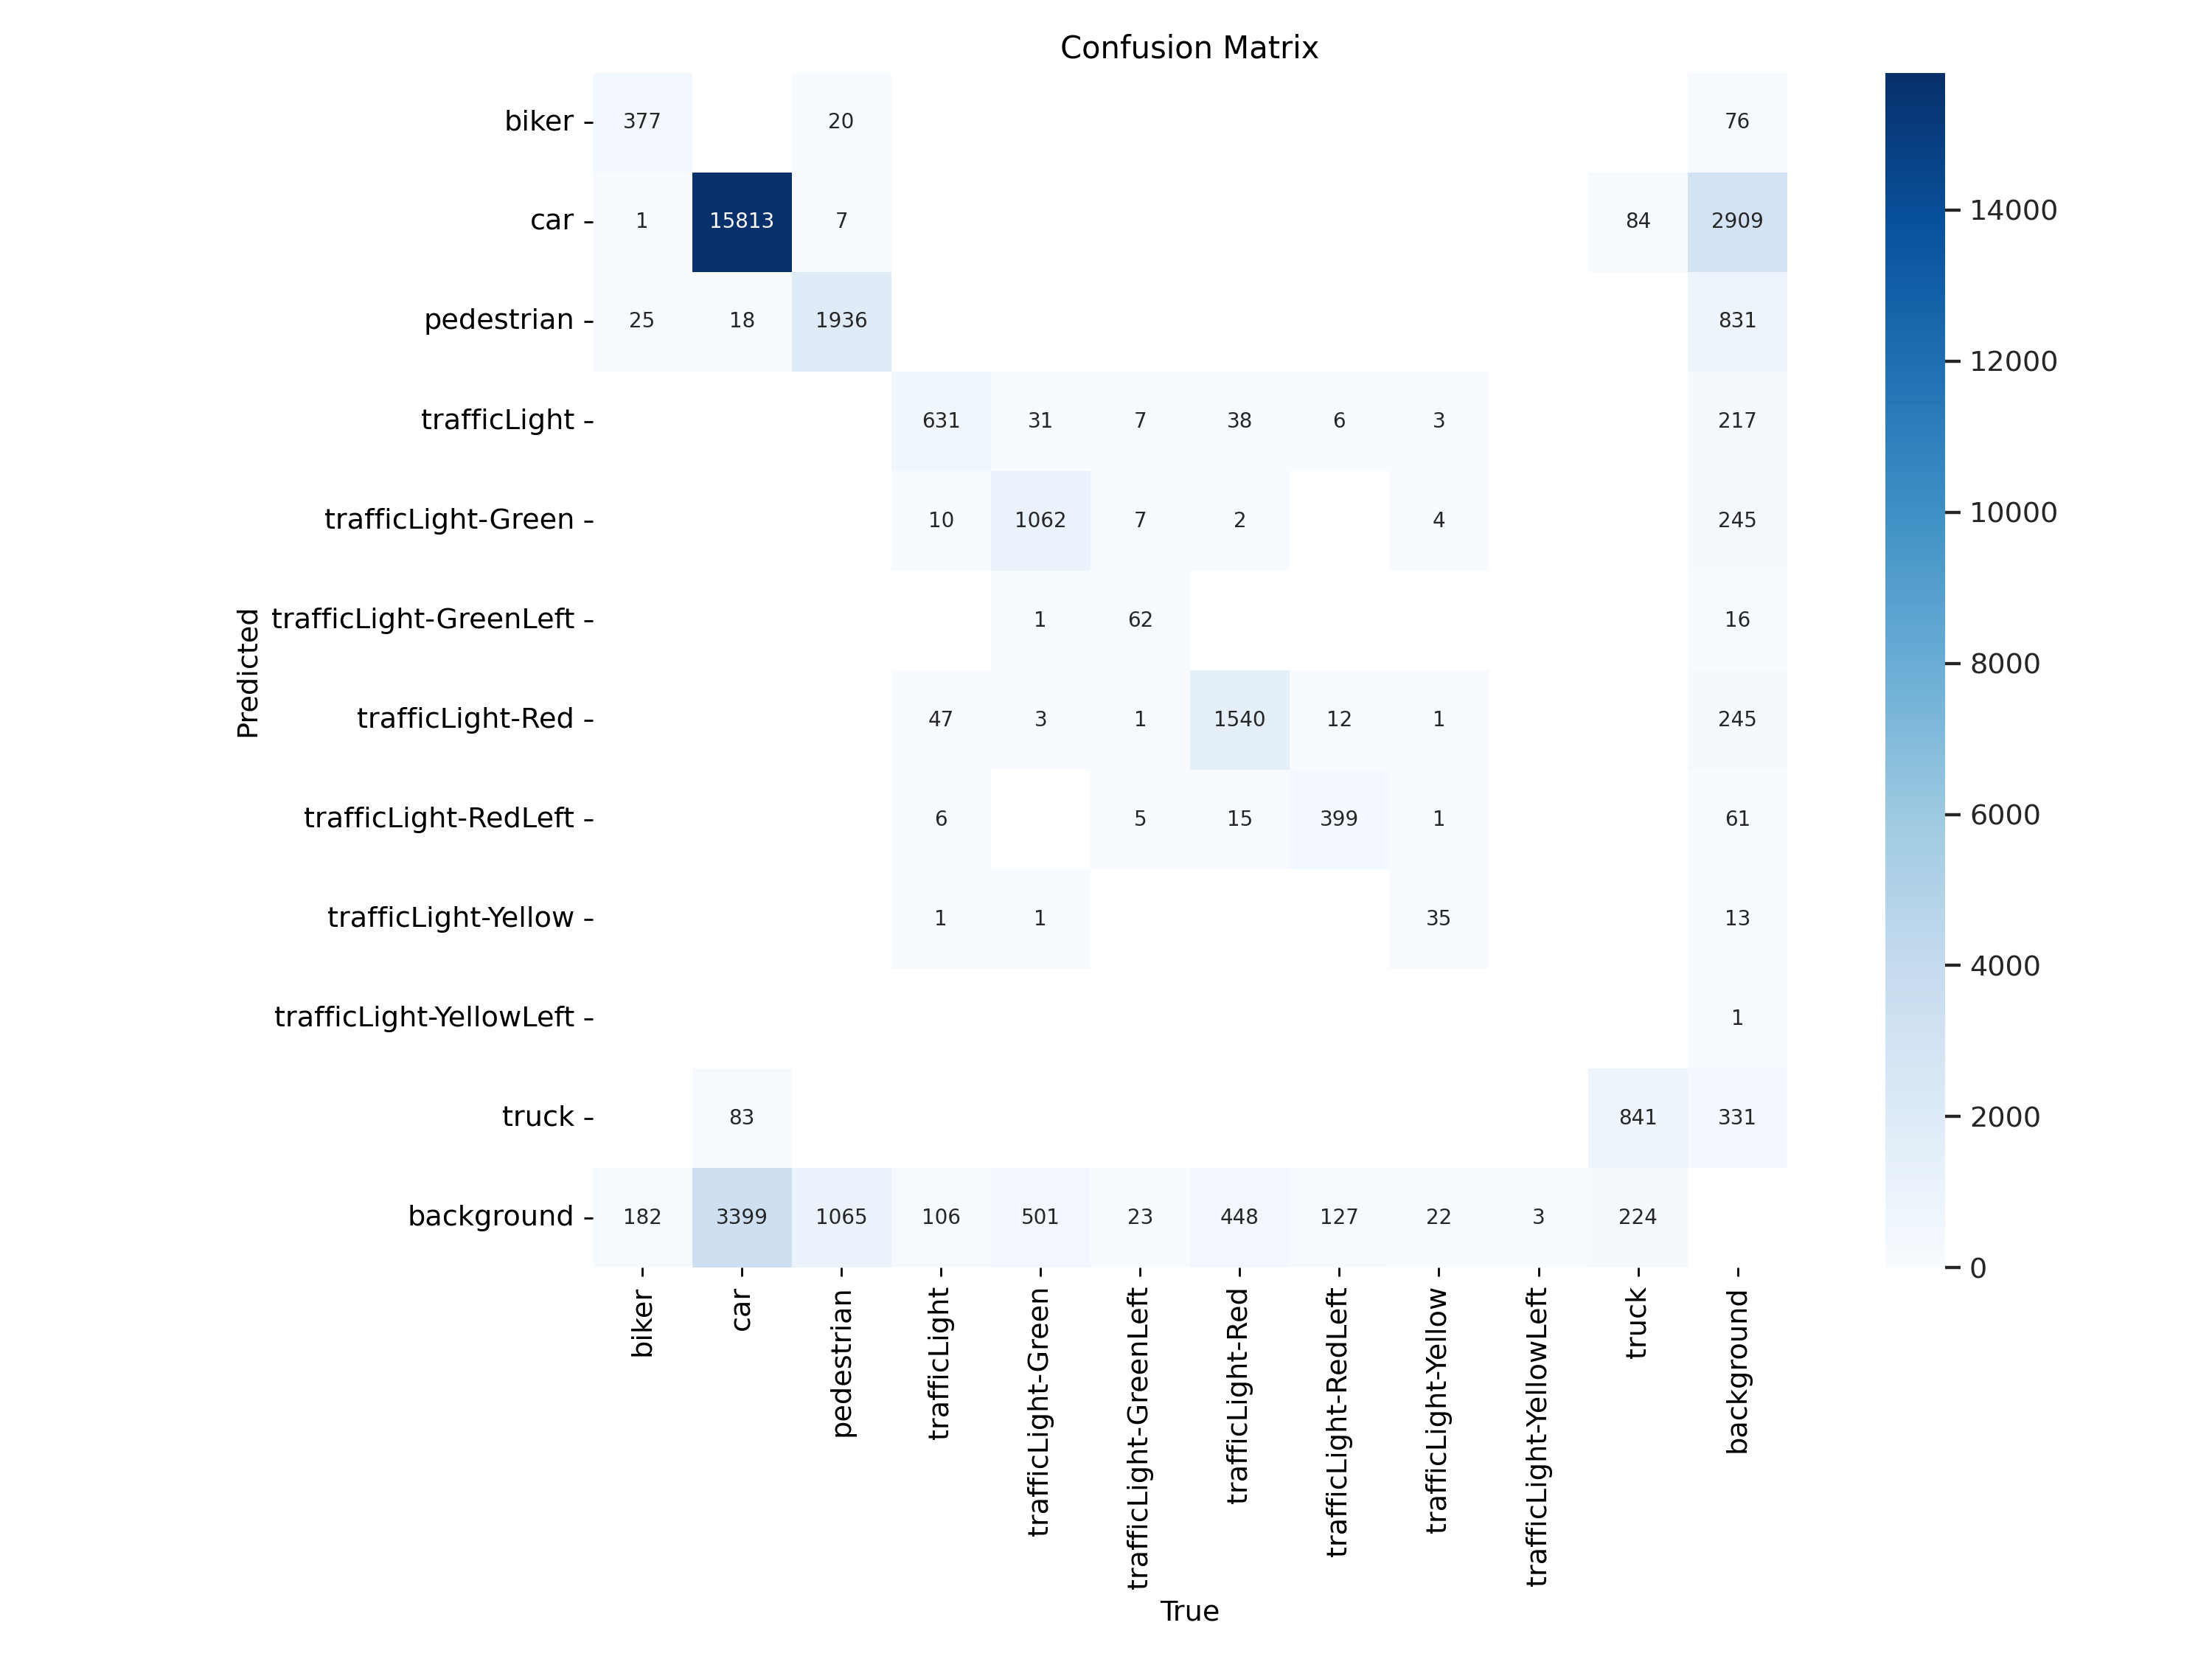

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

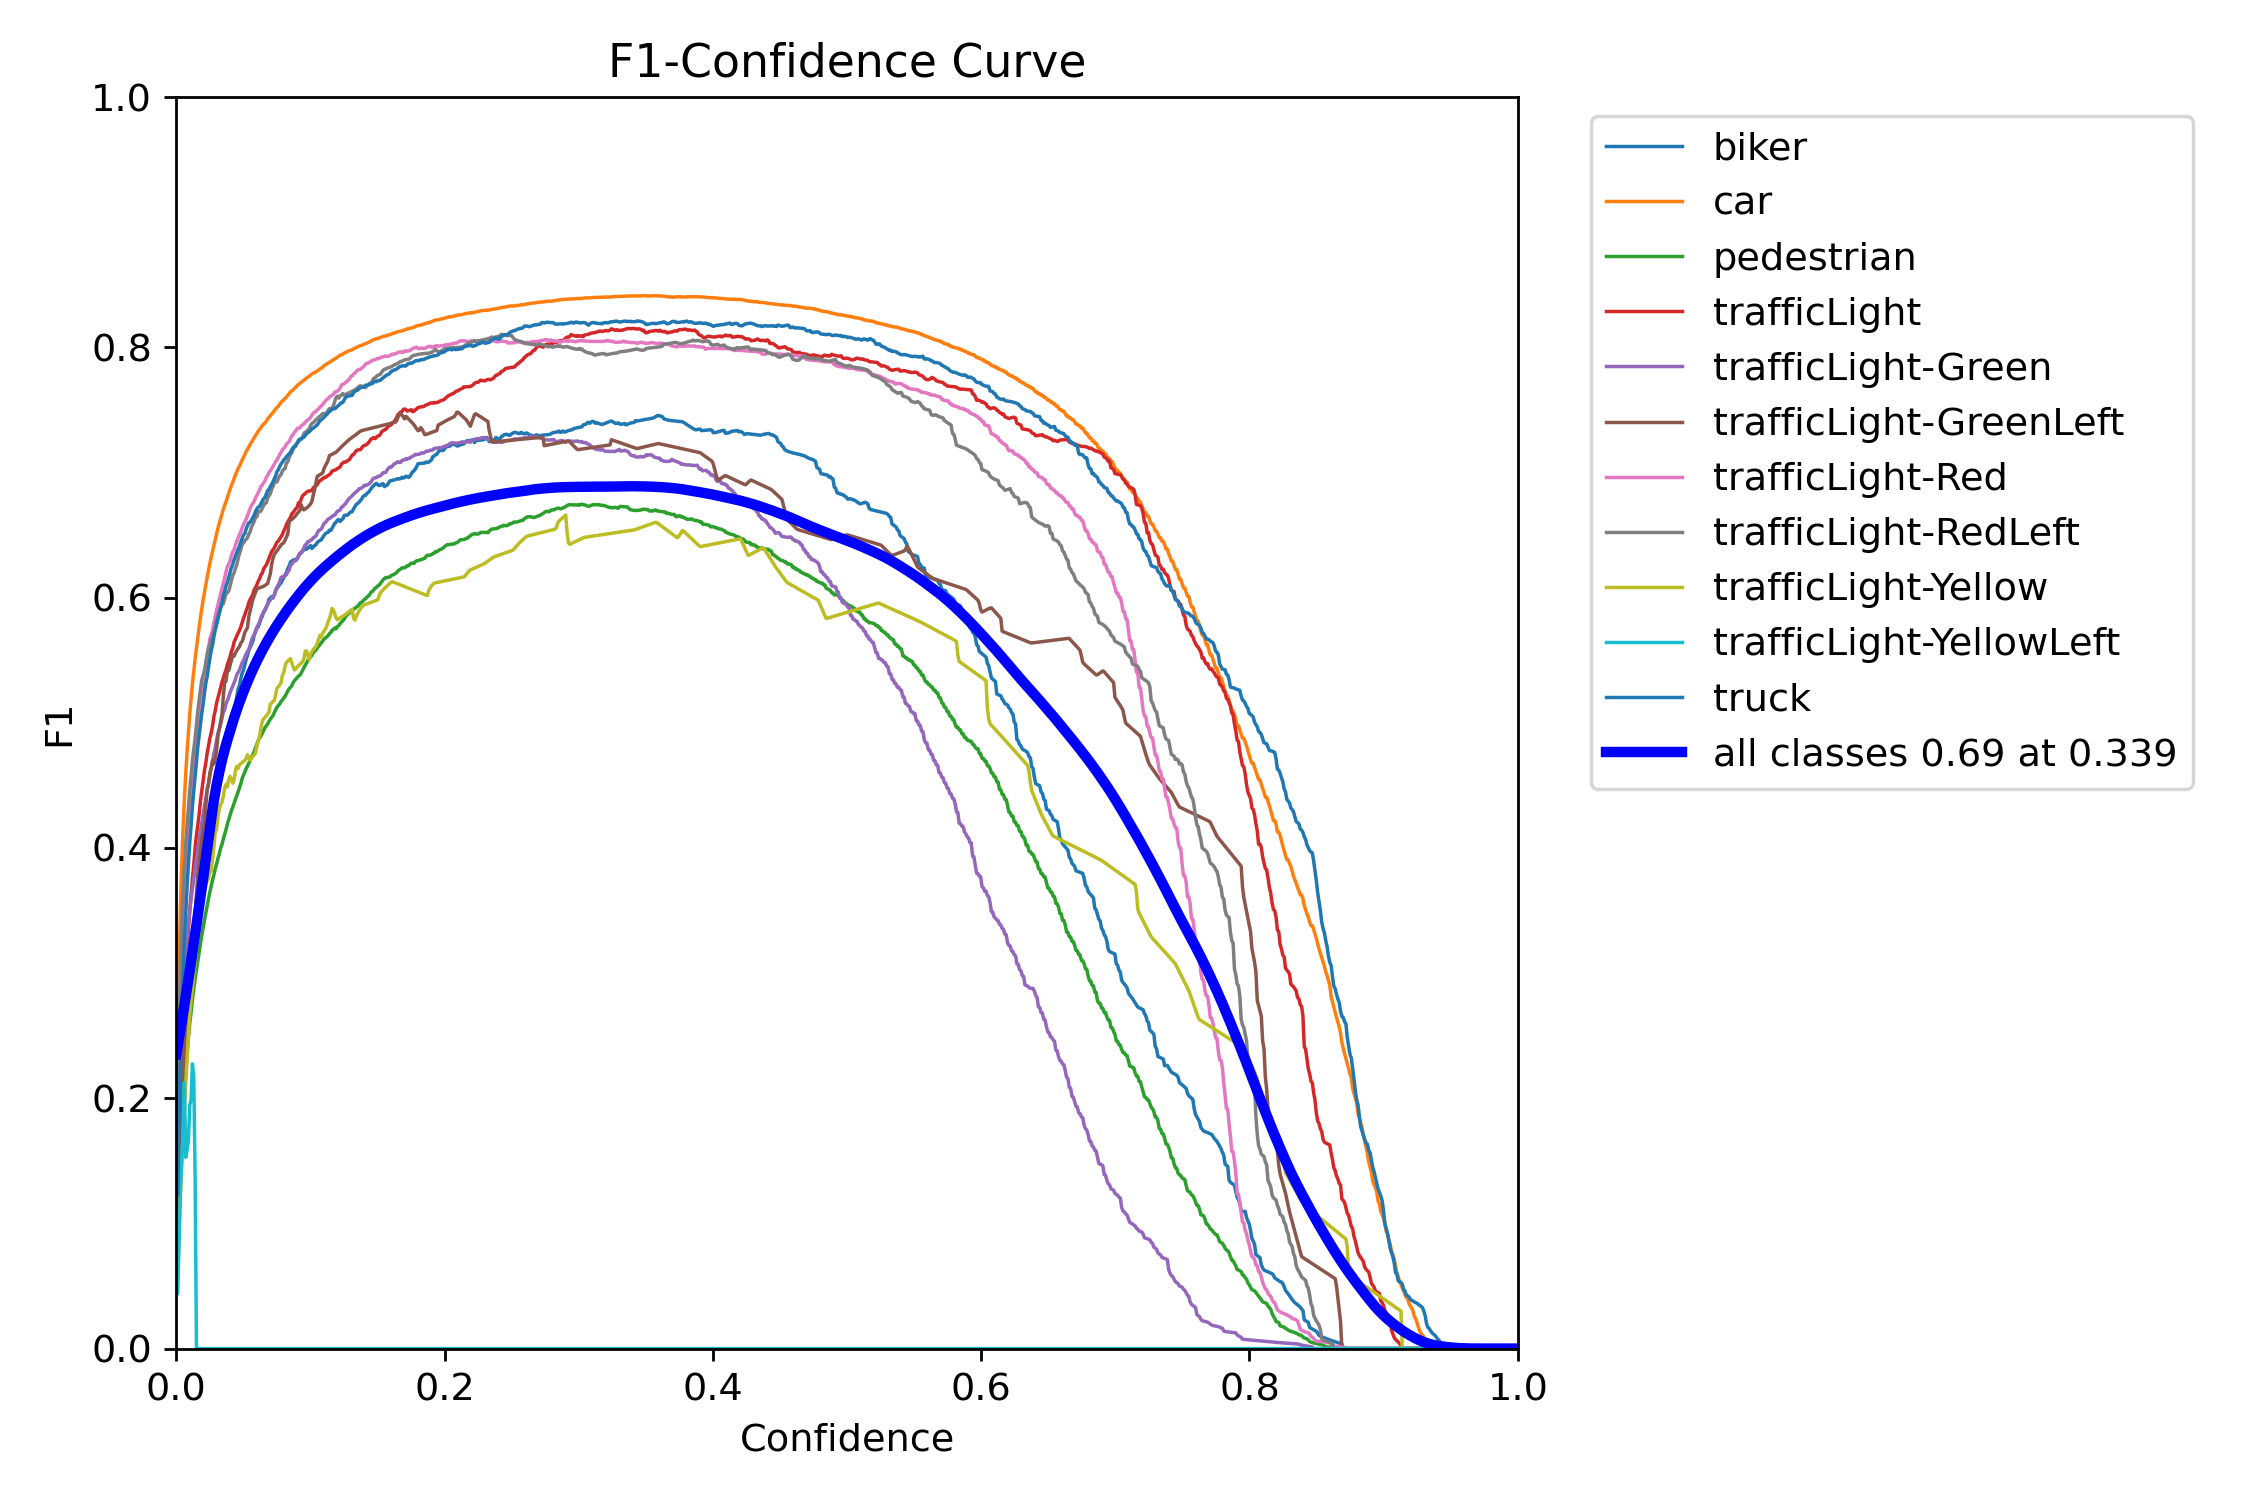

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/F1_curve.png', width=600)

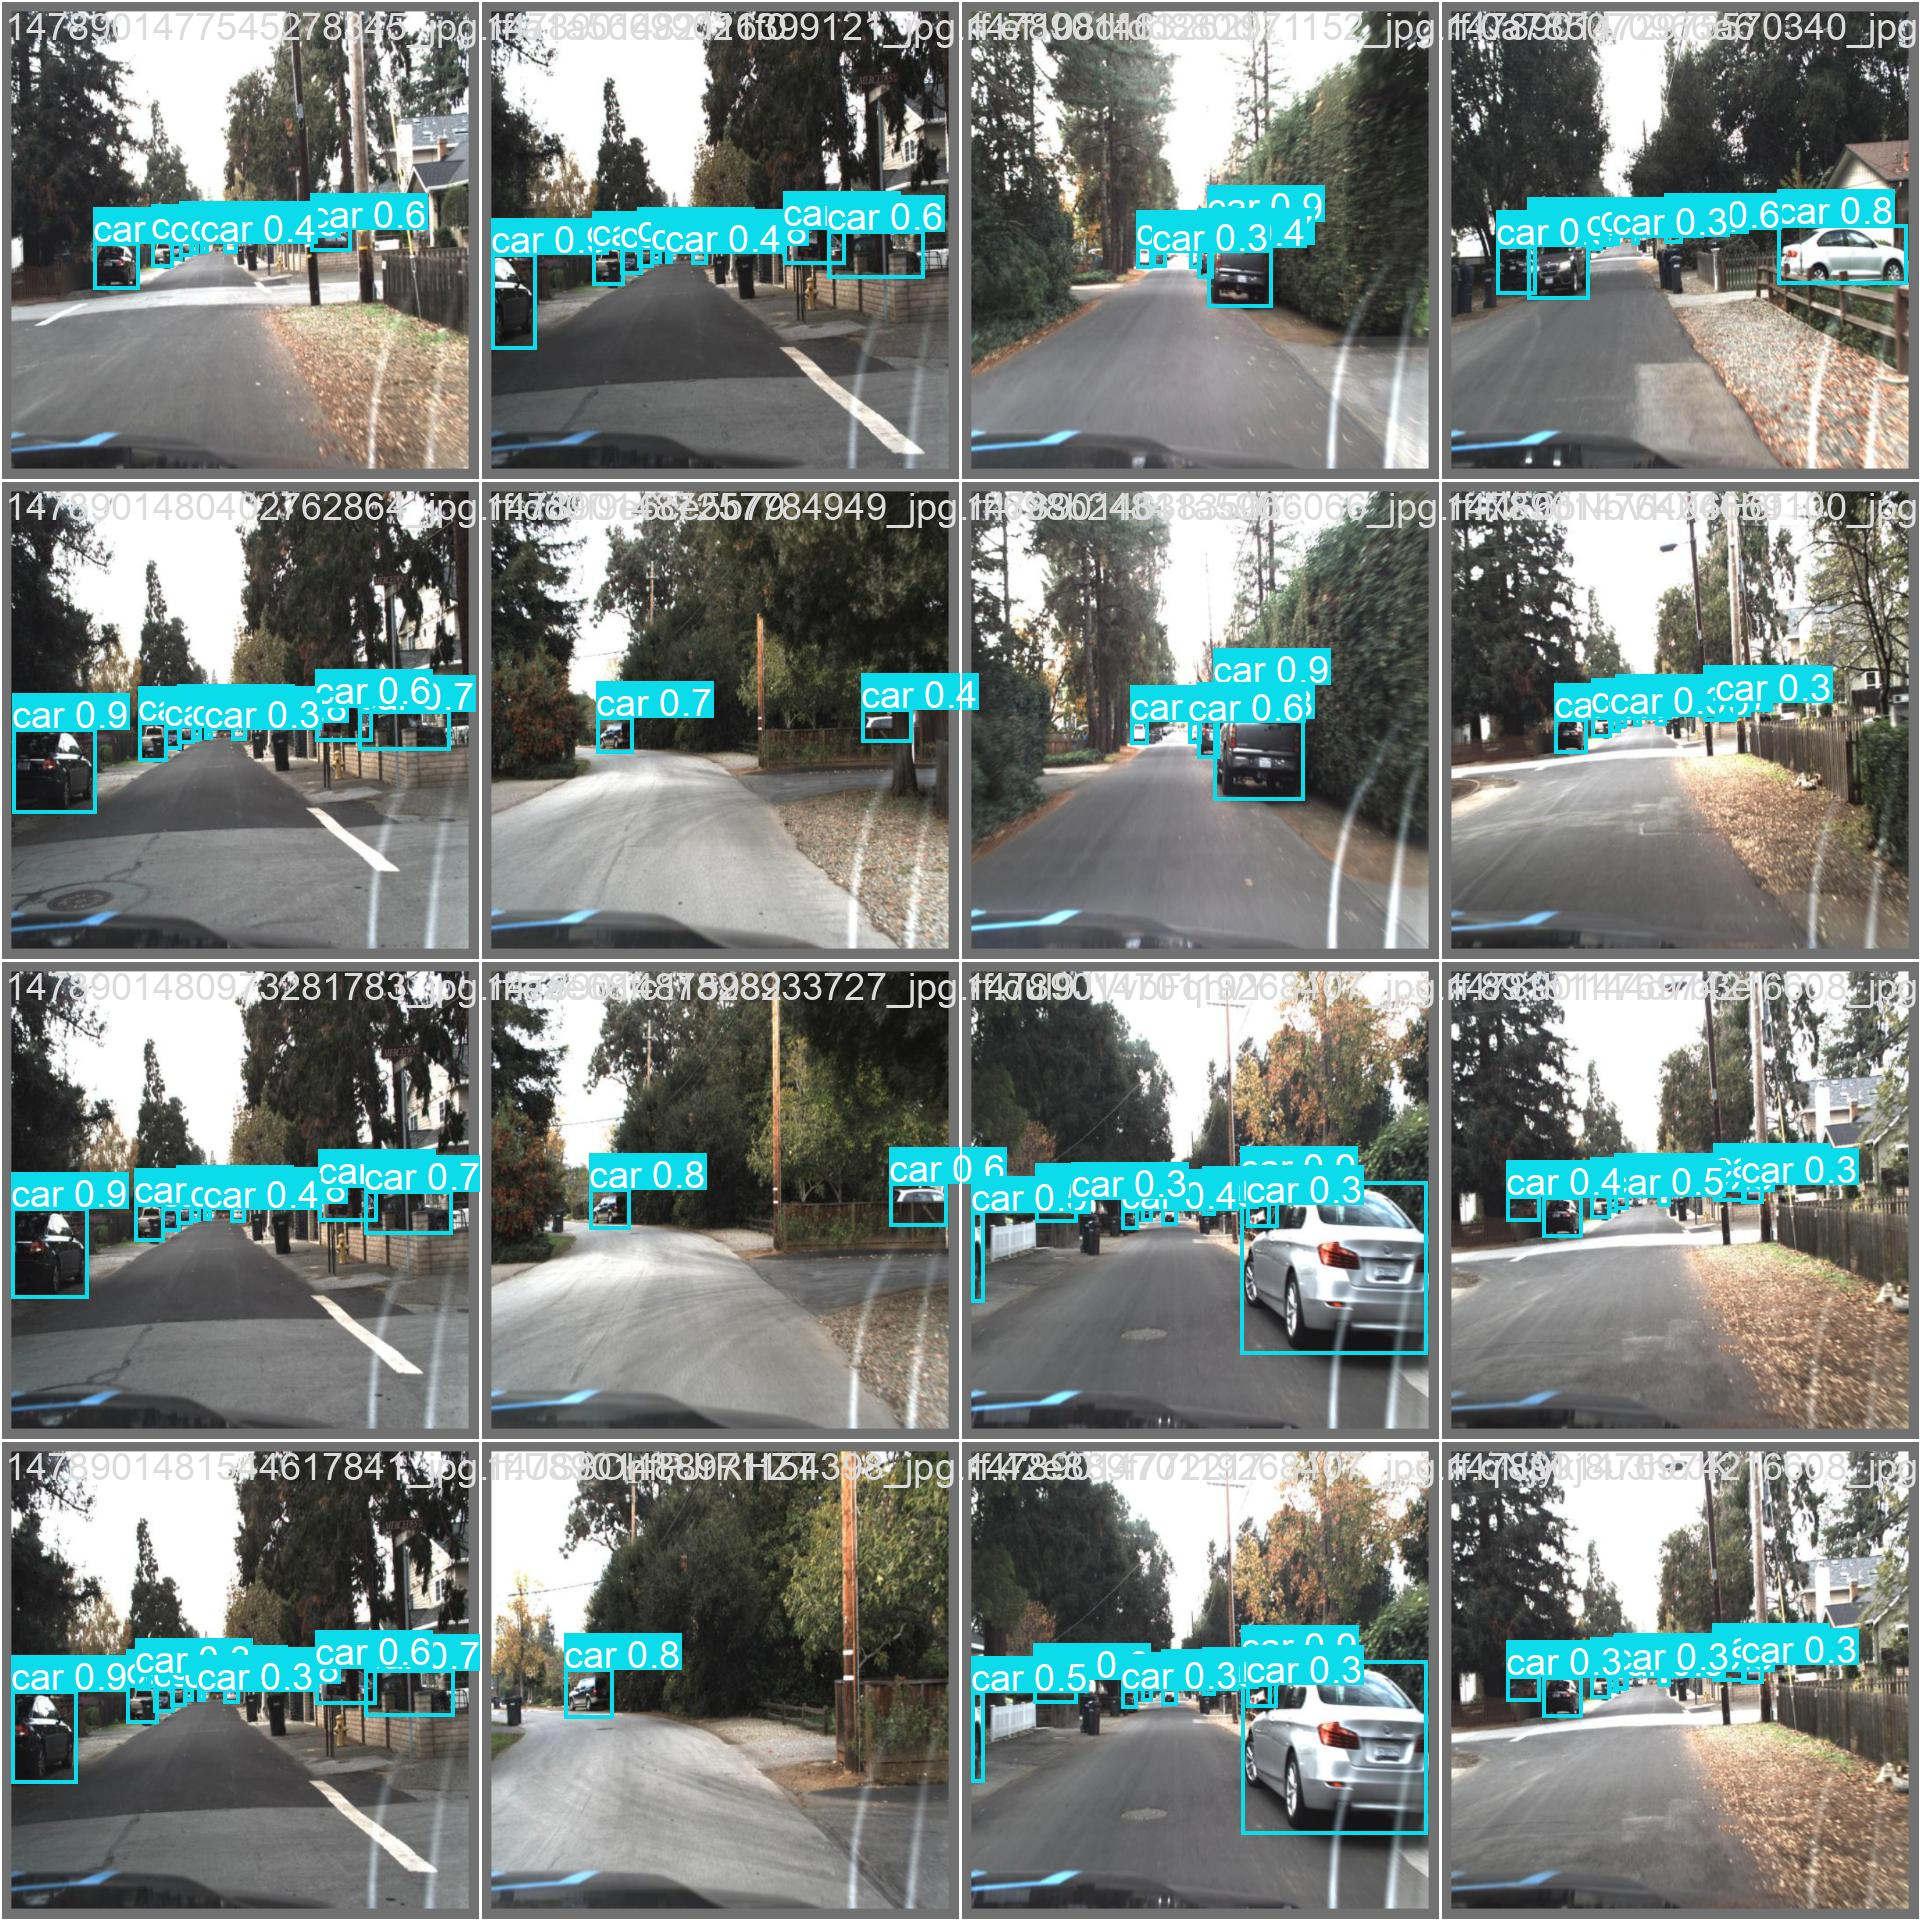

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['biker',
 'car',
 'pedestrian',
 'trafficLight',
 'trafficLight-Green',
 'trafficLight-GreenLeft',
 'trafficLight-Red',
 'trafficLight-RedLeft',
 'trafficLight-Yellow',
 'trafficLight-YellowLeft',
 'truck']

In [ ]:
from supervision.metrics import MeanAveragePrecision
from ultralytics import YOLO

model = YOLO(f'/content/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [ ]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.37894386414498615
mAP 50 0.6389154729544587
mAP 75 0.3984321529125063


## Inference with custom model

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,417,057 parameters, 0 gradients, 21.3 GFLOPs

image 1/4470 /content/datasets/Self-Driving-Car-3/test/images/1478019955185244088_jpg.rf.gJpj2eCO1Dd7Sic9WlhE.jpg: 640x640 3 cars, 1 truck, 15.6ms
image 2/4470 /content/datasets/Self-Driving-Car-3/test/images/1478019955679801306_jpg.rf.QnW1eAO23mmDm9ap1gm7.jpg: 640x640 3 cars, 1 truck, 15.7ms
image 3/4470 /content/datasets/Self-Driving-Car-3/test/images/1478019958682197101_jpg.rf.86b125654879c636e92f4bfb807fb296.jpg: 640x640 4 cars, 1 truck, 15.6ms
image 4/4470 /content/datasets/Self-Driving-Car-3/test/images/1478019958682197101_jpg.rf.XCoBnRWpmUTZFpYFGG3Y.jpg: 640x640 4 cars, 1 truck, 15.6ms
image 5/4470 /content/datasets/Self-Driving-Car-3/test/images/1478019959681353555_jpg.rf.e1760509335986edb309815ecd1c2401.jpg: 640x640 6 cars, 15.6ms
image 6/4470 /content/datasets/Self-Driving-Car-3/test/images/1478019961182003465_j

**NOTE:** Let's take a look at few results.

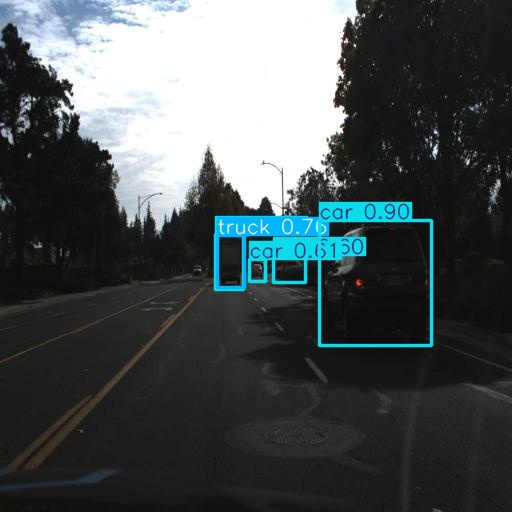

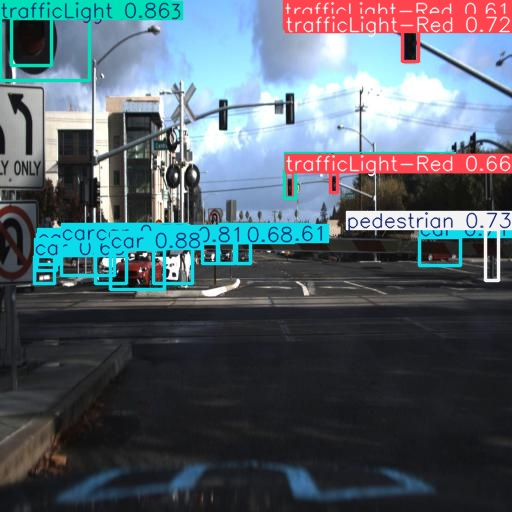

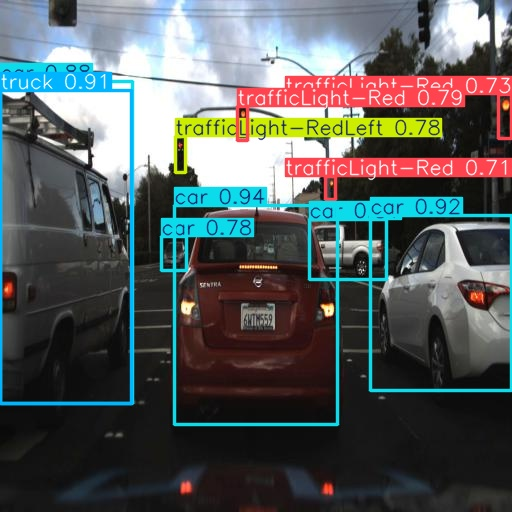

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")